# Summarize topics using LLM


Test how it performs when the text can be fitted into a fix size context window:


In [1]:
import openai
from getpass import getpass

openai.api_key = getpass("Enter your OpenAI API key: ")

In [3]:
GPT_MODEL = "gpt-3.5-turbo"


def chat(messages: list, prompt: str) -> str:
    messages.append({"role": "user", "content": prompt})
    responses = openai.ChatCompletion.create(
        model=GPT_MODEL,
        messages=messages,
    )
    return responses.choices[0]["message"]["content"]


def summarize(user_message: str) -> dict:
    messages = []
    system_message = """
    Role: Your role is to find the topics from the following messages and count how many messages in each topic.
    """
    messages.append({"role": "system", "content": system_message})

    prompt = f"""
    You are an assitant to find the topics from the following messages and count how many messages in each topic, output as a dictionary.
    
    Example:
    User: {{"I want to eat apple." : 1 }}
    {{"I want to eat orange." : 2 }}
    {{"Hiking is fun." : 3 }}
    {{"Redwoods is great for hiking." : 2 }}
    Assistant: {{"Eating Fruit": 3, "Hking": 5}}
    
    Now start:
    User: {user_message}
    Assistant:
    """
    response = chat(messages, prompt)
    return response


user_message = """
Is the camera specifically designed for outdoor use, and if so, what weather conditions can it withstand?
What is the Ingress Protection (IP) rating of the camera? (e.g., IP65, IP66, IP67) This indicates its resistance to dust and water.
Can the camera withstand extreme temperatures, such as high heat in summer or freezing cold in winter?
Is the camera sealed against moisture and rain, preventing water from entering the internal components?
Does the camera have a protective housing or casing to shield it from harsh weather elements?
How does the camera handle humidity and condensation, which can be common outdoor challenges?
Can the camera's lens and sensor resist fogging or clouding caused by rapid temperature changes?
Is the power source weather-resistant, and does it offer any additional protection against the elements?
Does the camera come with any warranty or guarantee regarding its weather resistance capabilities?
Are there any additional precautions or recommendations for installing the camera in specific weather conditions?
Is the camera designed with built-in privacy features, such as physical lens covers or the ability to disable recording and streaming when needed?
How is the camera's data stored, and what measures are in place to protect the stored footage from unauthorized access?
Does the camera support secure encryption protocols for data transmission between the camera and your connected devices (e.g., smartphone, computer)?
Are there any features that allow you to control when the camera is active and recording, such as scheduling recording times or geofencing?
Does the camera offer user access controls, so you can set different permission levels for family members or other users accessing the camera's feed?
Is the camera compliant with any privacy regulations or standards, such as GDPR (General Data Protection Regulation) or CCPA (California Consumer Privacy Act)?
Does the camera have local storage options, so you can store video footage on a microSD card or a local network-attached storage (NAS) device, reducing reliance on cloud storage?
Are there any features to anonymize or blur faces or sensitive information in recorded footage to protect the identity of individuals captured in the video?
Can the camera differentiate between different users in your household to prevent unnecessary alerts or recordings?
How does the camera handle software updates, and does the manufacturer regularly release updates to address security vulnerabilities?
What is the camera's maximum video resolution, and is it adjustable?
Does the camera support High Definition (HD) video (e.g., 720p, 1080p, etc.)?
Can the camera record in Ultra High Definition (UHD) or 4K resolution?
Is there a frames-per-second (FPS) specification for video recording, and how does it affect video smoothness?
What is the field of view (FOV) or viewing angle of the camera's lens?
How does the camera handle low-light or nighttime conditions? Is there night vision capability?
Does the camera use any image-enhancing technologies (e.g., HDR, WDR) to improve video quality in challenging lighting situations?
Can the camera handle dynamic lighting conditions, such as direct sunlight or glare?
Does the camera have any image stabilization features to reduce video shake and improve clarity?
How clear are the details captured by the camera during daytime and nighttime recordings?
"""
new_summary = summarize(user_message)
print("New summary:", new_summary)

New summary: {"Weather Resistance": 11, "Privacy and Security": 11, "Video Quality": 10}


Looks pretty good. Now scale up to larger dataset


## Summarize large dataset use mapreduce method

Use questions to ask when buying security cameras as an example


In [25]:
import pandas as pd
import tiktoken
from typing import List


def num_tokens(text: str, model: str = GPT_MODEL) -> int:
    """Return the number of tokens in a string."""
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))

Convert raw text into the desired chunks format


In [28]:
def convert_series_to_chunks(series) -> List[str]:
    chunks = []
    for row in series:
        new_text = row.replace("{", "").replace(
            "}", "").replace('"', "").replace("\n", " ")
        new_dict = {new_text: 1}
        chunks.append(str(new_dict))

    return chunks

Recurssively summarize the topics until 1 summary return


In [29]:
max_quota = 2500


def recursive_summarize(chunks: List[str]) -> List[str]:
    print("*******looping")
    if len(chunks) <= 1:
        return chunks

    quota = max_quota
    user_input = ""
    new_chunks = []

    for chunk in chunks:
        line = str(chunk) + '\n'
        quota -= num_tokens(line)
        user_input += line
        if quota < 0:
            new_chunk = summarize(user_input)
            new_chunks.append(new_chunk)
            quota = max_quota
            user_input = ""

    # Append the last bit:
    if quota < max_quota:
        new_chunk = summarize(user_input)
        new_chunks.append(new_chunk)

    return recursive_summarize(new_chunks)

In [35]:
df = pd.read_csv("security_camera_questions.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  185 non-null    object
dtypes: object(1)
memory usage: 1.6+ KB
None


,Question
0,What is the camera's resolution in megapixels?
1,Does the camera support 4K video?
2,Is the image quality clear enough to identify ...
3,How does the camera perform under different li...
4,Can I manually adjust the image settings?


In [ ]:
chunks = convert_series_to_chunks(df["Question"])
final_chunks = recursive_summarize(chunks)

In [39]:
import json

summary_dict = json.loads(final_chunks[0].replace('\n', ''))
print(summary_dict)

{'Camera Specification': 4, 'Image Quality': 7, 'Camera Features': 12, 'Power and Connectivity': 8, 'Storage and Cloud': 7, 'Night Vision and Motion Detection': 16, 'Audio and Microphone': 7, 'Camera Design and Installation': 7, 'Pricing and Warranty': 6, 'Software and Compatibility': 12, 'Security and Privacy': 16, 'Camera Functionality and Performance': 13, 'Camera Maintenance and Lifespan': 7, 'Additional Features': 7, 'Customer Support and Policies': 7, 'Advanced Camera Functionality': 13, 'Camera Recording and Streaming': 11, 'Camera Logs and Analytics': 8, 'Facial and Object Recognition': 13, 'Network Connection': 1, 'Mesh Networking': 1, 'Live Demo': 1, 'Zoom Functionality': 1, 'Power Outages': 1, 'Surge Protection': 1, 'Dual-Band Wi-Fi': 1, 'Recalibration Frequency': 1, '3D Mapping': 1, 'Environmental Certifications': 1, 'Sustainability': 1}


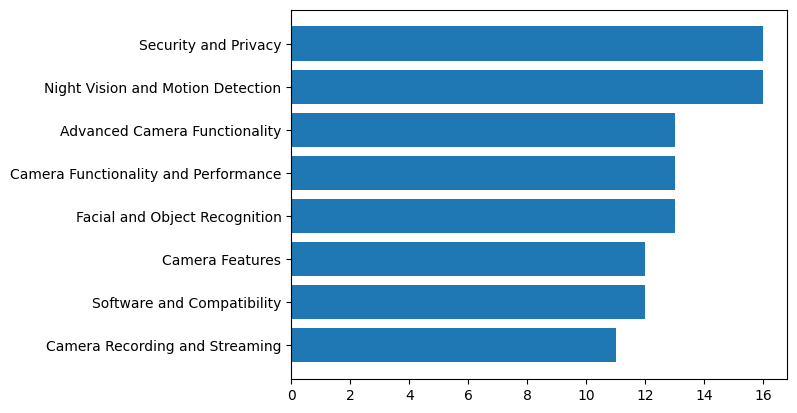

In [64]:
import matplotlib.pyplot as plt

topics = [(key, value) for key, value in summary_dict.items()]
df = pd.DataFrame(topics, columns=["Topics", "Counts"]).sort_values(
    "Counts", ascending=True)

df = df.tail(8)

plt.barh(df["Topics"], df["Counts"])
# df.head(5).plot(x='Topics', y='Counts', kind='bar',
#                 color='purple', title='Topics Count Plot')
plt.show()